In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import essentia.standard as es
import IPython
import pickle
from pickle import load
import ipywidgets as widgets
from utilities import *

## Select and Load audio

In [2]:
#Get all files with mp3 extension in the folder
path = 'test_audios'
audios = []
for file in os.listdir(path):
    if file.endswith(".mp3"):
        audios.append(os.path.join(path, file))

#Widget drop down menu
w = widgets.Dropdown(
    options=audios,
    value=audios[0],
    description='Song:',
)
w

Dropdown(description='Song:', options=('test_audios/Good_Cmaj_Sacle_legato.mp3', 'test_audios/MIDI_C_Maj_Scale…

In [3]:
audiofile = w.value
fs = 44100
# Loading audio file
x = es.MonoLoader(filename=audiofile)()
IPython.display.Audio(audiofile, rate=fs)

## Functions

In [4]:
#Create a full directory path for each file of the input data
def get_file_paths(path):
    sound_files = os.listdir(path)
    segments_dir = []
    for i in range(len(sound_files)):
        filepath = os.path.join(path, sound_files[i])
        segments_dir.append(filepath)
    return segments_dir

In [5]:
#Extract the features for the audio
def get_features(audiofile, scaler, start, stop):
    features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                              lowlevelFrameSize = 2048,
                                                              lowlevelHopSize = 1024,
                                                              lowlevelStats = ['mean', 'stdev'],
                                                              startTime = start, 
                                                              endTime = stop)(audiofile)
    scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
    selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
    X = str(selected_features)[1:-1] 
    X = np.array(X.split(','))
    X = X.reshape(1, -1)
    X = X.astype(np.float64)
    X_scaled = scaler.transform(X)
    return X_scaled

In [6]:
def load_txt(path, filename, n_delete_end):
    path = os.path.join(path, filename)
    file = open(path+'.txt', "r")
    content = file.read()
    content = content.split(",")
    file.close()
    content = content[:n_delete_end]
    return content

In [7]:
def select_features(descriptor, feature_names, extracted_features):
    #Obtain the selected features for this descriptor/klass
    selected_features = load_txt(path = 'selected_features', filename = descriptor, n_delete_end = -1 )

    #Find the indexes of the complete feature set that coincide
    feature_idx = []
    for i in range(len(feature_names)):
        for j in range(len(selected_features)):
            if feature_names[i] == selected_features[j]:
                feature_idx.append(i)

    #Save only the features that match de previously extracted indexes
    np_features = np.transpose(np.array(extracted_features))
    sel_features_array = np.transpose(np_features[feature_idx])
    
    return sel_features_array

## Feature extraction and predictions

In [8]:
#Obtain all the feature names
feature_names = load_txt(path = 'extracted_features', filename = 'feature_names', n_delete_end = -7 )

# load the scalers from the trainig data
Goodsound_scaler = load(open('scalers/Good-sound_scaler.pkl', 'rb'))
Badattack_scaler = load(open('scalers/Bad-attack_scaler.pkl', 'rb'))

#Get the model paths
models_dir = 'models/selected_features_SVM'
descriptors = ['Good-sound', 'Bad-attack', 'Bad-dynamics', 'Bad-pich', 'Bad-timber', 'Bad-richness']
model_paths = get_file_paths(models_dir)

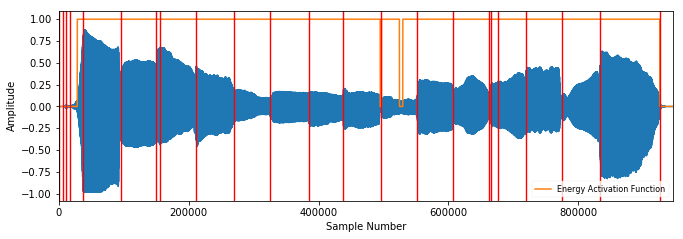

In [9]:
#Compute de decision function for the enregy threashold
split_decision_func, NRG_start_indexes, NRG_stop_indexes = sound_island(x)

#Upsample it to the same mumber of samples as the audio
is_there_NRG = np.around(signal.resample(split_decision_func, len(x)))

#Extract samples where the onsets happen
onset_array = onset_SOP(audiofile)*fs
onset_array = np.append(onset_array, NRG_stop_indexes[-1])

#Plot audio with onsets with the decision function
plt.rcParams["figure.figsize"] = (11,3.5)
plt.plot(x)
plt.plot(is_there_NRG, label = 'Energy Activation Function')
plt.xlim(0, len(x))
plt.style.use('seaborn-paper')

for onset in onset_array:
    plt.axvline(x=onset, color='r')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.title('')
plt.savefig('saved_plots/Segmentation_envolope')
plt.show()

In [10]:
#Separate each note to a different file
note_count = 0
onset_shift = 2700

#Generate the predictions array
seg_predictions = np.zeros((1, len(descriptors)))
predictions = []
start_array = []
stop_array = []
attack_start_array = []
attack_end_array = []
release_start_array = []
release_end_array = []
first_prediction = True
#For each segent, extract features and apply each one of the models
for i in range(len(onset_array)-1):
    start = int(onset_array[i])-onset_shift
    if start<0:
        start = 0
    stop = int(onset_array[i+1])-onset_shift 
    
    #only use segments that have enregy (no between silences)
    if np.mean(is_there_NRG[start:stop])>0.35:
        #only keep segments larger than 1/4 second
        if stop - start > fs/4:
            #Segment the whole audio between the onsets
            x_seg = x[start:stop]
            start_array.append(start)
            stop_array.append(stop)
            
            #Attack detection
            attack_start, attack_end = attack_detection(x_seg, M = 5)

            #Release detection (attack but flipped)
            x_flip = np.array(np.flip(x_seg))
            release_start_flip, release_end_flip = attack_detection(x_flip, M = 1.5)
            release_start = len(x_seg)-release_end_flip
            release_end = len(x_seg)-release_start_flip
                          
            #Condition if the attack is too short
            if attack_end-attack_start<fs/10:
                attack_end = attack_start+int(len(x_seg)*0.05)
            
            #Check that the attack end comes after the release start and is long enough for evaluation
            attack_release_diff = release_start-attack_end         
            if attack_release_diff>fs/8:
                
                #Calculate the exact sample for the whole audio, not only the segment
                attack_start_array.append(attack_start+onset_array[i])
                attack_end_array.append(attack_end+onset_array[i])
                release_start_array.append(release_start+onset_array[i])
                release_end_array.append(release_end+onset_array[i])
                
                #If we want to extract the features from the attack or not, select the right segments and scaler
                startTime_att = (attack_start+onset_array[i])/fs
                endTime_att = (attack_end+onset_array[i])/fs
                scaler_att = Badattack_scaler

                startTime = (attack_end+onset_array[i])/fs
                endTime = (release_start+onset_array[i])/fs
                scaler = Goodsound_scaler

                #Extract the features
                extracted_features = get_features(audiofile, scaler, startTime, endTime)
                extracted_features_att = get_features(audiofile, scaler_att, startTime_att, endTime_att)

                #Select the right features
                #selected_features = select_features(descriptors[j], feature_names, extracted_features)
                    
                for j in range(len(descriptors)):
                    if descriptors[j] == 'Bad-attack':
                        selected_features = select_features(descriptors[j], feature_names, extracted_features_att)
                    else:
                        selected_features = select_features(descriptors[j], feature_names, extracted_features)
                    #Obtain model name
                    model_name = os.path.join(models_dir, descriptors[j])
                    loaded_model = pickle.load(open(model_name, 'rb'))
                    seg_predictions[0, j] = loaded_model.predict_proba(selected_features)[:,0]              
                if first_prediction == True:
                    predictions = seg_predictions
                    first_prediction = False
                else:
                    predictions = np.vstack((predictions, seg_predictions))
                
                #Print results
                
                print("Note ",note_count, "\t\t GS:", seg_predictions[0, 0], 
                                 " Att:", seg_predictions[0, 1], 
                                 " Dyn:", seg_predictions[0, 2], 
                                 " Pi:", seg_predictions[0, 3],
                                 " Tim:", seg_predictions[0, 4],
                                 " Rich:", seg_predictions[0, 5],) 
                
                #Plot attack and release detection of each segment
                #plt.plot(x_seg)
                #plt.axvline(attack_end, c='b')
                #plt.axvline(release_start, c='r')
                #plt.show()

                note_count = note_count + 1

Note  0 		 GS: 0.9999998999999902  Att: 0.5412733410522809  Dyn: 0.021148272484329  Pi: 0.9999995137529102  Tim: 0.9999998999999902  Rich: 0.9999986322148909
Note  1 		 GS: 0.9999876514534802  Att: 0.9981236651521391  Dyn: 0.9999583883567883  Pi: 0.9999998999999902  Tim: 0.9999997981260421  Rich: 0.9977646133021063
Note  2 		 GS: 0.9999976399405953  Att: 0.37799653731821864  Dyn: 0.9394332795271966  Pi: 0.9999993987139382  Tim: 0.9999834568725988  Rich: 0.9464439389590669
Note  3 		 GS: 0.9999490247422643  Att: 0.9996742396301658  Dyn: 0.9881414914237898  Pi: 0.9999994800032178  Tim: 0.9999631529230361  Rich: 0.8819982817635549
Note  4 		 GS: 0.9997999295077196  Att: 0.9993630973859711  Dyn: 0.990527862709102  Pi: 0.9999998281898625  Tim: 0.9979450871256812  Rich: 0.6515586949271842
Note  5 		 GS: 0.998313940146577  Att: 0.9973223149835713  Dyn: 0.9980307605781832  Pi: 0.9999504291223632  Tim: 0.9990705745249352  Rich: 0.4809205384026043
Note  6 		 GS: 0.9981928888463878  Att: 0.999859

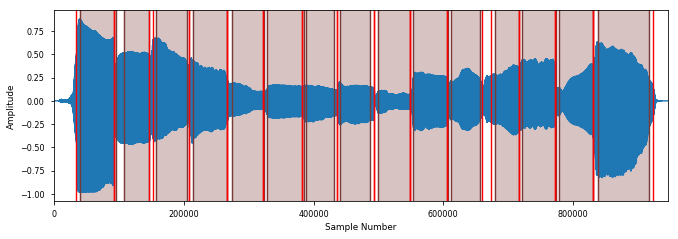

In [11]:
#Plot the signal with the segments analised in red. In blue are the onsets
plt.rcParams["figure.figsize"] = (11,3.5)
fig, ax = plt.subplots()
plt.xlim(0, len(x))
t = np.arange(0, len(x))
ax.plot(t, x)
plt.style.use('seaborn-paper')
color_st = '#783937FF'
color_on = 'r'
for i in range(len(attack_end_array)):
    ax.axvspan(attack_end_array[i], release_start_array[i], color = color_st, alpha = 0.3)
#    ax.axvspan(attack_start_array[i], attack_end_array[i], color = 'g', alpha = 0.3)
#    plt.axvline(x=attack_start_array[i], color='g')
    plt.axvline(x=attack_end_array[i], color=color_st)
    plt.axvline(x=release_start_array[i], color=color_st)
for i in range(len(start_array)):
    plt.axvline(x=start_array[i], color=color_on)
    plt.axvline(x=stop_array[i], color=color_on)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.title('')
plt.savefig('saved_plots/final_segments')
plt.show()


## Compute score

In [12]:
#Calculate a score from the predictions of each note
def compute_score(predictions):
    predictions_sig = logit(predictions)
    scores = np.mean(predictions_sig, axis=0)
    
    return scores

def logit(x):
    y = np.log(x/(1-x+4e-5)+1e-4)*0.05+0.5
    return y
    

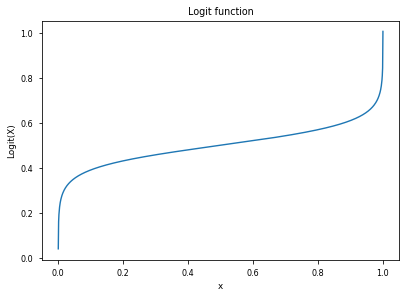

In [13]:
#Plot scoreing function
x = np.linspace(0, 1, 1000)
y = logit(x)
  
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("Logit(X)")
plt.title("Logit function")
plt.style.use('seaborn-paper')
plt.savefig('saved_plots/LogitFunction')
plt.show()
  
plt.show()

In [14]:
predictions_sig = logit(predictions)
predictions_sig

array([[0.9928787 , 0.81277315, 0.97067485, 1.00620671, 1.00607984,
        0.80416838],
       [0.9928787 , 0.81277315, 0.97067485, 1.00620671, 1.00607984,
        0.80416838],
       [1.00346511, 0.47510198, 0.63704387, 1.00558551, 0.98902452,
        0.64356209],
       [0.9652436 , 0.89566032, 0.7209707 , 1.00568572, 0.97368281,
        0.60055827],
       [0.91671889, 0.86486731, 0.73228352, 1.00611724, 0.80830932,
        0.53129182],
       [0.81801133, 0.79526469, 0.8104014 , 0.96602154, 0.84689386,
        0.4961838 ],
       [0.81461619, 0.93107089, 0.74088377, 1.00551303, 0.84622634,
        0.4867469 ],
       [0.94823767, 0.77750825, 0.94352144, 1.00620671, 0.9266494 ,
        0.53449178],
       [0.61752628, 0.92463574, 0.65631792, 0.95240911, 0.65366731,
        0.43251413],
       [0.93482685, 0.63929719, 0.58990693, 0.95592898, 0.88050922,
        0.5682163 ],
       [1.00611173, 0.95341449, 0.69274664, 0.98851331, 0.93516467,
        0.66058211],
       [1.00620671, 0

In [15]:
scores = compute_score(predictions)
scores

array([0.93534093, 0.78249413, 0.62443618, 0.99504393, 0.92109796,
       0.63702985])

## Plot the results

In [16]:
x = 0.001
y = np.log(x/(1-x))*0.05+0.5
y

0.1546622610675723

In [17]:
audiofile

'test_audios/Good_Cmaj_Sacle_legato.mp3'

In [18]:
#Create a file name to save the plot
base = os.path.splitext(audiofile)[0]
plot_name = base+".png"
plot_name

'test_audios/Good_Cmaj_Sacle_legato.png'

In [19]:
import plotly.express as px
def radar_plot(scores, categories):
    df = pd.DataFrame(dict(
        r=scores,
        theta=categories))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True, title=plot_name)
    fig.update_traces(fill='toself')
    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )
    fig.show()
    fig.write_image(plot_name)


In [20]:
categories = ['Attack', 'Dynamics', 'Pitch', 'Timber', 'Richness']
radar_plot(scores[1:], categories)